Our goal will be to predict item sales per month of various products sold by a Russian software company. To do this, we will utilize historic item sales data in order to train a regression model (kaggle link: https://www.kaggle.com/c/competitive-data-science-predict-future-sales).

Start by loading the necessary libraries and the dataset

In [28]:
import pandas as pd
import numpy as np
import datetime

train = pd.read_csv('sales_train.csv')
item_cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')

Take a look at the training data head to start

In [29]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


First column to deal with is the date

In [30]:
train['datetime_date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')
train['month'] = train['datetime_date'].dt.month
train['year'] = train['datetime_date'].dt.year
train = train.drop(columns = ['date', 'datetime_date'])

We are interested in predicting sale counts for an entire month, not just one day. Therefore we need to do some grouping on the columns.

In [65]:
train_new = train.groupby(['shop_id', 'item_id', 'month', 'year', 'date_block_num']).agg({'item_cnt_day': 'sum', 'item_price': 'mean'})
train_new = train_new.reset_index()
train_new.head()

,shop_id,item_id,month,year,date_block_num,item_cnt_day,item_price
0,0,30,2,2013,1,31.0,265.0
1,0,31,2,2013,1,11.0,434.0
2,0,32,1,2013,0,6.0,221.0
3,0,32,2,2013,1,10.0,221.0
4,0,33,1,2013,0,3.0,347.0


Histogram of item_cnt_day values

(0, 20)

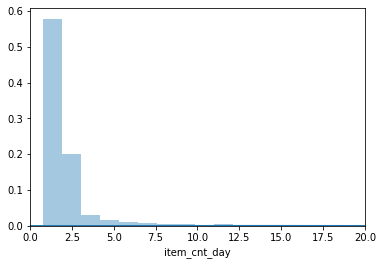

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(train_new['item_cnt_day'], bins = 2000)
plt.xlim(0, 20)

Distribution of item_cnt_day is very right skewed. We'd like the response variable to have a normal distribution so need to address this later on before training the model.

Next look at total item sales in each date_block_num

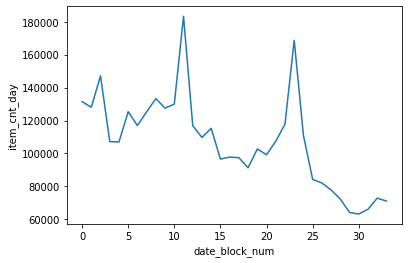

In [70]:
sales_by_date = train_new.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'})
sales_by_date = sales_by_date.reset_index()
sns.lineplot(sales_by_date['date_block_num'], sales_by_date['item_cnt_day'])

There's clearly two spikes in months 12 and 24, which are both in December. This suggests that holiday shopping drives up sales during that time. Overall, however, there is a downward trend in sale values.

(0, 50000)

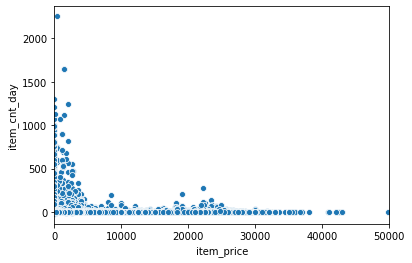

In [74]:
sns.scatterplot(train_new['item_price'], train_new['item_cnt_day'])
plt.xlim(0, 50000)

Higher priced items appear to have less sales. However, let's consider revenue as well.

(0, 50000)

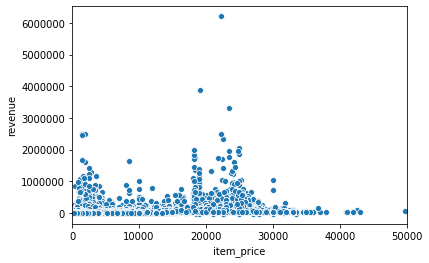

In [80]:
train_new['revenue'] = train_new['item_price'] * train_new['item_cnt_day']
sns.scatterplot(train_new['item_price'], train_new['revenue'])
plt.xlim(0, 50000)

Comparing this to the previous plot, we can see that the lower priced items aren't necessarily better from a revenue standpoint.

We want to know what category each of these items belongs to. Thus we now merge with the items table.

In [32]:
train_new = train_new.merge(items, how = 'left', on = 'item_id')
train_new = train_new.drop(columns = 'item_name')
train_new

,shop_id,item_id,month,year,date_block_num,item_cnt_day,item_price,item_category_id
0,0,30,2,2013,1,31.0,265.0,40
1,0,31,2,2013,1,11.0,434.0,37
2,0,32,1,2013,0,6.0,221.0,40
3,0,32,2,2013,1,10.0,221.0,40
4,0,33,1,2013,0,3.0,347.0,37
...,...,...,...,...,...,...,...,...
1609119,59,22164,4,2015,27,2.0,699.0,37
1609120,59,22164,7,2015,30,1.0,699.0,37
1609121,59,22167,6,2014,17,1.0,299.0,49
1609122,59,22167,10,2013,9,1.0,299.0,49


We now want to create some new features to add to the datset. We start with looking at how long it has been since the product was released.

In [33]:
df = train_new[['item_id', 'date_block_num']]
df = df.sort_values(by = ['item_id', 'date_block_num'])
df = df.drop_duplicates(subset = ['item_id'], keep = 'first')
df.columns = ['item_id', 'date_first_introduced']
train_new = train_new.merge(df, how = 'left', on = 'item_id')
train_new['months_since_release'] = train_new['date_block_num'] - train_new['date_first_introduced']
train_new['new_product'] = np.where(train_new['months_since_release'] == 0, 1, 0)
train_new

,shop_id,item_id,month,year,date_block_num,item_cnt_day,item_price,item_category_id,date_first_introduced,months_since_release,new_product
0,0,30,2,2013,1,31.0,265.0,40,1,0,1
1,0,31,2,2013,1,11.0,434.0,37,1,0,1
2,0,32,1,2013,0,6.0,221.0,40,0,0,1
3,0,32,2,2013,1,10.0,221.0,40,0,1,0
4,0,33,1,2013,0,3.0,347.0,37,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1609119,59,22164,4,2015,27,2.0,699.0,37,25,2,0
1609120,59,22164,7,2015,30,1.0,699.0,37,25,5,0
1609121,59,22167,6,2014,17,1.0,299.0,49,8,9,0
1609122,59,22167,10,2013,9,1.0,299.0,49,8,1,0


Next we look at if the product is more expensive or cheaper than its counterparts within the category.

In [34]:
cat_prices = train_new[['date_block_num', 'item_price', 'item_category_id']]
cat_prices = cat_prices.groupby(['date_block_num', 'item_category_id']).agg({'item_price': 'mean'})
cat_prices = cat_prices.reset_index()
cat_prices.columns = ['date_block_num', 'item_category_id', 'category_avg_price']
train_new = train_new.merge(cat_prices, how = 'left', on = ['date_block_num', 'item_category_id'])
train_new['pct_from_category_avg'] = (train_new['item_price'] - train_new['category_avg_price']) / train_new['category_avg_price']
train_new

,shop_id,item_id,month,year,date_block_num,item_cnt_day,item_price,item_category_id,date_first_introduced,months_since_release,new_product,category_avg_price,pct_from_category_avg
0,0,30,2,2013,1,31.0,265.0,40,1,0,1,215.843519,0.227741
1,0,31,2,2013,1,11.0,434.0,37,1,0,1,459.996722,-0.056515
2,0,32,1,2013,0,6.0,221.0,40,0,0,1,213.911584,0.033137
3,0,32,2,2013,1,10.0,221.0,40,0,1,0,215.843519,0.023890
4,0,33,1,2013,0,3.0,347.0,37,0,0,1,456.995262,-0.240692
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,59,22164,4,2015,27,2.0,699.0,37,25,2,0,455.920124,0.533163
1609120,59,22164,7,2015,30,1.0,699.0,37,25,5,0,403.237776,0.733469
1609121,59,22167,6,2014,17,1.0,299.0,49,8,9,0,425.300334,-0.296967
1609122,59,22167,10,2013,9,1.0,299.0,49,8,1,0,444.363367,-0.327127


In [35]:
train_new = train_new.sort_values(by = ['item_id', 'date_block_num'])
train_new['recent_sale_time'] = train_new['item_cnt_day'].shift()
train_new['recent_sale_time'] = train_new['recent_sale_time'].fillna(value = 0)
train_new['previous_row_item'] = train_new['item_id'].shift()
train_new['recent_sale_time'] = np.where(train_new['item_id'] != train_new['previous_row_item'], 0, train_new['recent_sale_time'])
train_new['recent_sale_time'] = np.where(train_new['new_product'] == 1, 0, train_new['recent_sale_time'])
train_new

,shop_id,item_id,month,year,date_block_num,item_cnt_day,item_price,item_category_id,date_first_introduced,months_since_release,new_product,category_avg_price,pct_from_category_avg,recent_sale_time,previous_row_item
1358997,54,0,9,2014,20,1.0,58.0,40,20,0,1,233.584091,-0.751695,0.0,NaN
1429468,55,1,4,2014,15,2.0,4490.0,76,15,0,1,1534.380000,1.926263,0.0,0.0
1429469,55,1,7,2014,18,1.0,4490.0,76,15,3,0,1882.240476,1.385455,2.0,1.0
1429470,55,1,8,2014,19,1.0,4490.0,76,15,4,0,1858.437523,1.416008,1.0,1.0
1429471,55,1,9,2014,20,1.0,4490.0,76,15,5,0,1943.461033,1.310311,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306412,16,22168,2,2013,1,1.0,799.0,62,0,1,0,1042.960792,-0.233912,1.0,22168.0
1069529,42,22168,2,2013,1,1.0,799.0,62,0,1,0,1042.960792,-0.233912,1.0,22168.0
1091249,43,22168,3,2013,2,1.0,798.5,62,0,2,0,936.786655,-0.147618,1.0,22168.0
208367,12,22168,9,2013,8,1.0,799.0,62,0,8,0,1105.796105,-0.277444,1.0,22168.0


Now we apply a similar idea for shops instead.

In [36]:
train_new = train_new.sort_values(by = ['shop_id', 'date_block_num'])
train_new['recent_shop_success'] = train_new['item_cnt_day'].shift()
train_new['recent_shop_success'] = train_new['recent_shop_success'].fillna(value = 0)
train_new['previous_row_item'] = train_new['shop_id'].shift()
train_new['recent_sale_time'] = np.where(train_new['item_id'] != train_new['previous_row_item'], 0, train_new['recent_sale_time'])
train_new['recent_sale_time'] = np.where(train_new['new_product'] == 1, 0, train_new['recent_sale_time'])
train_new

,shop_id,item_id,month,year,date_block_num,item_cnt_day,item_price,item_category_id,date_first_introduced,months_since_release,new_product,category_avg_price,pct_from_category_avg,recent_sale_time,previous_row_item,recent_shop_success
2,0,32,1,2013,0,6.0,221.0,40,0,0,1,213.911584,0.033137,0.0,NaN,0.0
4,0,33,1,2013,0,3.0,347.0,37,0,0,1,456.995262,-0.240692,0.0,0.0,6.0
6,0,35,1,2013,0,1.0,247.0,40,0,0,1,213.911584,0.154683,0.0,0.0,3.0
11,0,43,1,2013,0,1.0,221.0,40,0,0,1,213.911584,0.033137,0.0,0.0,1.0
13,0,51,1,2013,0,2.0,128.5,57,0,0,1,277.710067,-0.537287,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608994,59,22087,10,2015,33,6.0,119.0,83,0,33,0,141.481569,-0.158901,0.0,59.0,1.0
1609026,59,22088,10,2015,33,2.0,119.0,83,0,33,0,141.481569,-0.158901,0.0,59.0,6.0
1609043,59,22091,10,2015,33,1.0,179.0,83,0,33,0,141.481569,0.265182,0.0,59.0,2.0
1609073,59,22100,10,2015,33,1.0,629.0,42,30,3,0,1150.500771,-0.453282,0.0,59.0,1.0


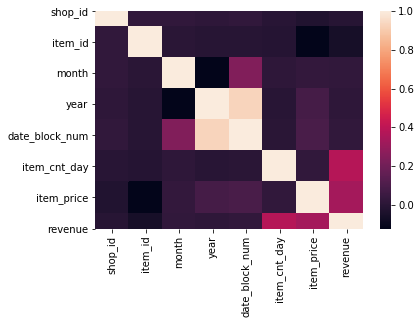

In [81]:
sns.heatmap(train_new.corr())

In [ ]:
from sklearn import datasets, ensemble




params = {'n_estimators': 100,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 2.0,
          'loss': 'ls'}
# best so far: 100, 2, 5, 2

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X, y)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, reg.predict(X))
mse

In [84]:
train_new

,shop_id,item_id,month,year,date_block_num,item_cnt_day,item_price,revenue,store_slope_x,cat_strength,cat_strength*date_block,store_strength,store_slope_y,date_block_num^2
0,0,30,2,2013,1,31.0,265.0,8215.0,263.298150,8215.0,8215.0,1376.673350,263.298150,1
1,0,31,2,2013,1,11.0,434.0,4774.0,263.298150,4774.0,4774.0,1376.673350,263.298150,1
2,0,32,1,2013,0,6.0,221.0,1326.0,263.298150,1326.0,0.0,1376.673350,263.298150,0
3,0,32,2,2013,1,10.0,221.0,2210.0,263.298150,2210.0,2210.0,1376.673350,263.298150,1
4,0,33,1,2013,0,3.0,347.0,1041.0,263.298150,1041.0,0.0,1376.673350,263.298150,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,59,22164,4,2015,27,2.0,699.0,1398.0,23.321074,1398.0,37746.0,1807.915771,23.321074,729
1609120,59,22164,7,2015,30,1.0,699.0,699.0,23.321074,699.0,20970.0,1807.915771,23.321074,900
1609121,59,22167,6,2014,17,1.0,299.0,299.0,23.321074,299.0,5083.0,1807.915771,23.321074,289
1609122,59,22167,10,2013,9,1.0,299.0,299.0,23.321074,299.0,2691.0,1807.915771,23.321074,81
